In [3]:
%run ../0-utils/0-Base.ipynb

Read data that will be used for training / testing:

In [4]:
%%time

feature_matrix_dfs = dict()

for feature_matrix_clazz in ("train", "test"):
    feature_matrix_df = pd.read_csv(f"../data/2-feature-engineered/{feature_matrix_clazz}.csv")
    feature_matrix_df = feature_matrix_df.drop("MODE(transactions.merchant_id)", axis=1)
    feature_matrix_df = feature_matrix_df.set_index("card_id")
    
    display(feature_matrix_df)

    feature_matrix_dfs[feature_matrix_clazz] = feature_matrix_df

,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_1,feature_2,feature_3,SUM(transactions.month_lag),SUM(transactions.purchase_amount),SUM(transactions.month_diff),STD(transactions.month_lag),STD(transactions.purchase_amount),STD(transactions.month_diff),MAX(transactions.month_lag),MAX(transactions.purchase_amount),MAX(transactions.month_diff),SKEW(transactions.month_lag),SKEW(transactions.purchase_amount),SKEW(transactions.month_diff),MIN(transactions.month_lag),MIN(transactions.purchase_amount),MIN(transactions.month_diff),MEAN(transactions.month_lag),MEAN(transactions.purchase_amount),MEAN(transactions.month_diff),COUNT(transactions),PERCENT_TRUE(transactions.authorized_flag),PERCENT_TRUE(transactions.category_1),PERCENT_TRUE(transactions.category_2_1),PERCENT_TRUE(transactions.category_2_2),PERCENT_TRUE(transactions.category_2_3),PERCENT_TRUE(transactions.category_2_4),PERCENT_TRUE(transactions.category_2_5),PERCENT_TRUE(transactions.category_2_-1),PERCENT_TRUE(transactions.category_3_0),PERCENT_TRUE(transactions.category_3_1),PERCENT_TRUE(transactions.category_3_2),PERCENT_TRUE(transactions.category_3_-1),PERCENT_TRUE(transactions.installments_-1),PERCENT_TRUE(transactions.installments_0),PERCENT_TRUE(transactions.installments_1),PERCENT_TRUE(transactions.installments_2),PERCENT_TRUE(transactions.installments_3),PERCENT_TRUE(transactions.installments_4),PERCENT_TRUE(transactions.installments_5),PERCENT_TRUE(transactions.installments_6),PERCENT_TRUE(transactions.installments_7),PERCENT_TRUE(transactions.installments_8),PERCENT_TRUE(transactions.installments_9),PERCENT_TRUE(transactions.installments_10),PERCENT_TRUE(transactions.installments_11),PERCENT_TRUE(transactions.installments_12),PERCENT_TRUE(transactions.installments_999),NUM_UNIQUE(transactions.city_id),NUM_UNIQUE(transactions.merchant_category_id),NUM_UNIQUE(transactions.merchant_id),NUM_UNIQUE(transactions.state_id),NUM_UNIQUE(transactions.subsector_id),NUM_UNIQUE(transactions.installments),NUM_UNIQUE(transactions.category_2),NUM_UNIQUE(transactions.category_3),MODE(transactions.city_id),MODE(transactions.merchant_category_id),MODE(transactions.state_id),MODE(transactions.subsector_id),MODE(transactions.installments),MODE(transactions.category_2),MODE(transactions.category_3),DAY(first_active_month),YEAR(first_active_month),MONTH(first_active_month),WEEKDAY(first_active_month),COUNT(transactions WHERE authorized_flag = 1),COUNT(transactions WHERE installments_10 = 1),COUNT(transactions WHERE installments_8 = 1),COUNT(transactions WHERE installments_11 = 1),COUNT(transactions WHERE category_1 = 1),COUNT(transactions WHERE installments_6 = 1),COUNT(transactions WHERE installments_999 = 1),COUNT(transactions WHERE category_3_-1 = 1),COUNT(transactions WHERE category_2_-1 = 1),COUNT(transactions WHERE category_3_0 = 1),COUNT(transactions WHERE installments_2 = 1),COUNT(transactions WHERE category_2_1 = 1),COUNT(transactions WHERE installments_9 = 1),COUNT(transactions WHERE installments_3 = 1),COUNT(transactions WHERE category_2_5 = 1),COUNT(transactions WHERE category_2_4 = 1),COUNT(transactions WHERE category_3_2 = 1),COUNT(transactions WHERE installments_-1 = 1),COUNT(transactions WHERE category_2_2 = 1),COUNT(transactions WHERE installments_12 = 1),COUNT(transactions WHERE category_2_3 = 1),COUNT(transactions WHERE installments_0 = 1),COUNT(transactions WHERE installments_1 = 1),COUNT(transactions WHERE installments_7 = 1),COUNT(transactions WHERE installments_5 = 1),COUNT(transactions WHERE installments_4 = 1),COUNT(transactions WHERE category_3_1 = 1),NUM_UNIQUE(transactions.DAY(purchase_date)),NUM_UNIQUE(transactions.YEAR(purchase_date)),NUM_UNIQUE(transactions.MONTH(purchase_date)),NUM_UNIQUE(transactions.WEEKDAY(purchase_date)),MODE(transactions.DAY(purchase_date)),MODE(transactions.YEAR(purchase_date)),MODE(transactions.MONTH(purchase_date)),MODE(transactions.WEEKDAY(purchase_date))
card_id,,,,,,

,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_1,feature_2,feature_3,SUM(transactions.month_lag),SUM(transactions.purchase_amount),SUM(transactions.month_diff),STD(transactions.month_lag),STD(transactions.purchase_amount),STD(transactions.month_diff),MAX(transactions.month_lag),MAX(transactions.purchase_amount),MAX(transactions.month_diff),SKEW(transactions.month_lag),SKEW(transactions.purchase_amount),SKEW(transactions.month_diff),MIN(transactions.month_lag),MIN(transactions.purchase_amount),MIN(transactions.month_diff),MEAN(transactions.month_lag),MEAN(transactions.purchase_amount),MEAN(transactions.month_diff),COUNT(transactions),PERCENT_TRUE(transactions.authorized_flag),PERCENT_TRUE(transactions.category_1),PERCENT_TRUE(transactions.category_2_1),PERCENT_TRUE(transactions.category_2_2),PERCENT_TRUE(transactions.category_2_3),PERCENT_TRUE(transactions.category_2_4),PERCENT_TRUE(transactions.category_2_5),PERCENT_TRUE(transactions.category_2_-1),PERCENT_TRUE(transactions.category_3_0),PERCENT_TRUE(transactions.category_3_1),PERCENT_TRUE(transactions.category_3_2),PERCENT_TRUE(transactions.category_3_-1),PERCENT_TRUE(transactions.installments_-1),PERCENT_TRUE(transactions.installments_0),PERCENT_TRUE(transactions.installments_1),PERCENT_TRUE(transactions.installments_2),PERCENT_TRUE(transactions.installments_3),PERCENT_TRUE(transactions.installments_4),PERCENT_TRUE(transactions.installments_5),PERCENT_TRUE(transactions.installments_6),PERCENT_TRUE(transactions.installments_7),PERCENT_TRUE(transactions.installments_8),PERCENT_TRUE(transactions.installments_9),PERCENT_TRUE(transactions.installments_10),PERCENT_TRUE(transactions.installments_11),PERCENT_TRUE(transactions.installments_12),PERCENT_TRUE(transactions.installments_999),NUM_UNIQUE(transactions.city_id),NUM_UNIQUE(transactions.merchant_category_id),NUM_UNIQUE(transactions.merchant_id),NUM_UNIQUE(transactions.state_id),NUM_UNIQUE(transactions.subsector_id),NUM_UNIQUE(transactions.installments),NUM_UNIQUE(transactions.category_2),NUM_UNIQUE(transactions.category_3),MODE(transactions.city_id),MODE(transactions.merchant_category_id),MODE(transactions.state_id),MODE(transactions.subsector_id),MODE(transactions.installments),MODE(transactions.category_2),MODE(transactions.category_3),DAY(first_active_month),YEAR(first_active_month),MONTH(first_active_month),WEEKDAY(first_active_month),COUNT(transactions WHERE authorized_flag = 1),COUNT(transactions WHERE installments_10 = 1),COUNT(transactions WHERE installments_8 = 1),COUNT(transactions WHERE installments_11 = 1),COUNT(transactions WHERE category_1 = 1),COUNT(transactions WHERE installments_6 = 1),COUNT(transactions WHERE installments_999 = 1),COUNT(transactions WHERE category_3_-1 = 1),COUNT(transactions WHERE category_2_-1 = 1),COUNT(transactions WHERE category_3_0 = 1),COUNT(transactions WHERE installments_2 = 1),COUNT(transactions WHERE category_2_1 = 1),COUNT(transactions WHERE installments_9 = 1),COUNT(transactions WHERE installments_3 = 1),COUNT(transactions WHERE category_2_5 = 1),COUNT(transactions WHERE category_2_4 = 1),COUNT(transactions WHERE category_3_2 = 1),COUNT(transactions WHERE installments_-1 = 1),COUNT(transactions WHERE category_2_2 = 1),COUNT(transactions WHERE installments_12 = 1),COUNT(transactions WHERE category_2_3 = 1),COUNT(transactions WHERE installments_0 = 1),COUNT(transactions WHERE installments_1 = 1),COUNT(transactions WHERE installments_7 = 1),COUNT(transactions WHERE installments_5 = 1),COUNT(transactions WHERE installments_4 = 1),COUNT(transactions WHERE category_3_1 = 1),NUM_UNIQUE(transactions.DAY(purchase_date)),NUM_UNIQUE(transactions.YEAR(purchase_date)),NUM_UNIQUE(transactions.MONTH(purchase_date)),NUM_UNIQUE(transactions.WEEKDAY(purchase_date)),MODE(transactions.DAY(purchase_date)),MODE(transactions.YEAR(purchase_date)),MODE(transactions.MONTH(purchase_date)),MODE(transactions.WEEKDAY(purchase_date))
card_id,,,,,,

CPU times: user 3.45 s, sys: 289 ms, total: 3.74 s
Wall time: 3.74 s


Check for missing values:

In [5]:
for feature_matrix_clazz, feature_matrix_df in feature_matrix_dfs.items():
    print(feature_matrix_clazz.upper() + ":")
    
    cols_with_nulls = feature_matrix_df.columns[feature_matrix_df.isnull().any()].tolist()
    
    display(cols_with_nulls)

TRAIN:


['SKEW(transactions.month_lag)',
 'SKEW(transactions.purchase_amount)',
 'SKEW(transactions.month_diff)']

TEST:


['SKEW(transactions.month_lag)',
 'SKEW(transactions.purchase_amount)',
 'SKEW(transactions.month_diff)']

Get rid of missing values:

In [6]:
for feature_matrix_clazz, feature_matrix_df in feature_matrix_dfs.items():
    cols_with_nulls = feature_matrix_df.columns[feature_matrix_df.isnull().any()].tolist()
    
    for skew_col in filter(lambda x: x.startswith("SKEW"), cols_with_nulls):
        feature_matrix_df[skew_col].fillna(feature_matrix_df[skew_col].mode()[0], inplace=True)
    
    print(f"{feature_matrix_clazz.upper()} has {feature_matrix_df.isnull().sum().sum()} missing values!")

TRAIN has 0 missing values!
TEST has 0 missing values!


In [19]:
from sklearn.preprocessing import StandardScaler

X_train, y_train = feature_matrix_dfs["train"].drop("target", axis=1), feature_matrix_dfs["train"].target

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = feature_matrix_dfs["test"].drop("target", axis=1)
X_test = scaler.transform(X_test)

/home/data-scientist/miniconda3/envs/elo-competition/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/data-scientist/miniconda3/envs/elo-competition/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/data-scientist/miniconda3/envs/elo-competition/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [15]:
%%time

from keras.models import Sequential
from keras.layers import Dense, Dropout

regressor = Sequential()

regressor.add(Dense(512, input_dim=X_train.shape[1], activation="relu"))
regressor.add(Dropout(0.5))

regressor.add(Dense(1024, activation="relu"))
regressor.add(Dropout(0.5))

regressor.add(Dense(512, activation="relu"))
regressor.add(Dropout(0.5))

regressor.add(Dense(256, activation="relu"))
regressor.add(Dropout(0.5))

regressor.add(Dense(1))

regressor.compile(optimizer="adam", loss="mse")

regressor.fit(X_train, y_train, batch_size=256, epochs=5)

Epoch 1/5
201917/201917 [==============================] - 17s 84us/step - loss: 14.5336
Epoch 2/5
201917/201917 [==============================] - 17s 83us/step - loss: 14.3173
Epoch 3/5
201917/201917 [==============================] - 17s 83us/step - loss: 14.2903
Epoch 4/5
201917/201917 [==============================] - 17s 82us/step - loss: 14.2528
Epoch 5/5
201917/201917 [==============================] - 17s 82us/step - loss: 14.1958
CPU times: user 8min 6s, sys: 9.23 s, total: 8min 16s
Wall time: 1min 24s


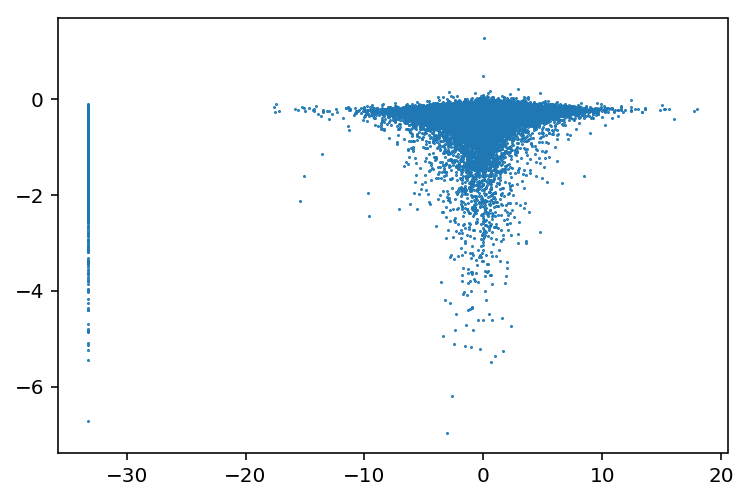

In [18]:
plt.scatter(y_train, regressor.predict(X_train), s=0.25);

In [20]:
%%time

y_test = regressor.predict(X_test)

CPU times: user 26.4 s, sys: 845 ms, total: 27.2 s
Wall time: 5.99 s


In [21]:
submission_df = feature_matrix_dfs["test"].assign(target=y_test).loc[:, ["target"]]

display(submission_df)
    
submission_df.to_csv("../submission.csv")

,target
card_id,
C_ID_0079d1f5ee,-0.241739
C_ID_00d20cfaa6,-0.236815
C_ID_023ee72d50,-0.227318
...,...
C_ID_fe91e3fc9f,-0.192863
C_ID_ff02b057f5,-0.165677
C_ID_ffbb1f9527,-0.212057
